<a href="https://colab.research.google.com/github/anmol-pabla/VAE-Omniglot/blob/master/VAE_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import plot_model # can plot model graphically

In [ ]:
tfds.disable_progress_bar()
tf.enable_v2_behavior()

x_size, y_size = 28, 28

# SK: load as supervised => u will get tuple instead of dictionary
ds_trains = tfds.load(
    'omniglot',
    split='train',
    shuffle_files=True,
    with_info=False,
    as_supervised=True,
)

def normalize_img(image, label):
  image = tf.image.resize(image, [x_size, y_size]) 
  image = tf.cast(image, tf.float32) / 255.
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 3]) # Random crop back to 28x28
  # image = tf.image.random_brightness(image, max_delta=0.5) # Random brightnes
  return image,image # SK: replace labels with input images >> will be easy at model.fit

ds_trains = ds_trains.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE) # SK: resize and normalise
ds_trains = ds_trains.cache() # SK: to store it in memory > will yield faster run
ds_trains = ds_trains.shuffle(1000) # SK: will shuffle the dataset for randomness
ds_trains = ds_trains.batch(128) # SK: take small random batches of 128 
ds_trains = ds_trains.prefetch(tf.data.experimental.AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteBIK9XM/omniglot-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteBIK9XM/omniglot-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteBIK9XM/omniglot-small1.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteBIK9XM/omniglot-small2.tfrecord
Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.


In [ ]:
# SK: this should print different labels both the time >> random batches

for example in ds_trains.take(2):
  images, labels = example[0], example[1]
  print(images.shape, labels.shape, np.mean(labels))

(128, 28, 28, 3) (128, 28, 28, 3) 0.80657196
(128, 28, 28, 3) (128, 28, 28, 3) 0.808853


In [ ]:
# original_dim = 784
latent_size = 640

# SK: use tf instead of keras
def sampling(args):
    z_mean, z_log_sigma = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return eps * tf.exp(z_log_sigma * .5) + z_mean

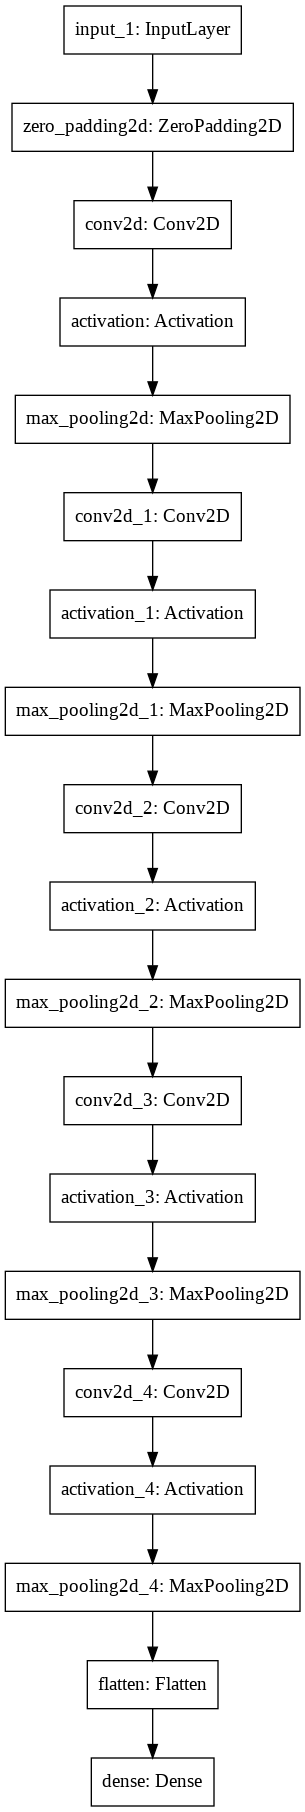

In [ ]:
def get_encoder_model():
  inputs = tf.keras.Input((x_size,y_size,3))
  x = tf.keras.layers.ZeroPadding2D(padding=2)(inputs)
  for n in [32,64,128,128,128]:
      x = tf.keras.layers.Conv2D(n, kernel_size=3, padding='same')(x)
      x = tf.keras.layers.Activation('relu')(x)
      x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

  x = tf.keras.layers.Flatten()(x)
  z_m_v = tf.keras.layers.Dense(2*latent_size)(x) # double of latent size z_m_v[:laten_size] = mean and z_m_v[laten_size:] = sigma

  model = tf.keras.Model(inputs, z_m_v, name='encoder')

  return model

encoder = get_encoder_model()
plot_model(encoder)
# encoder.summary()

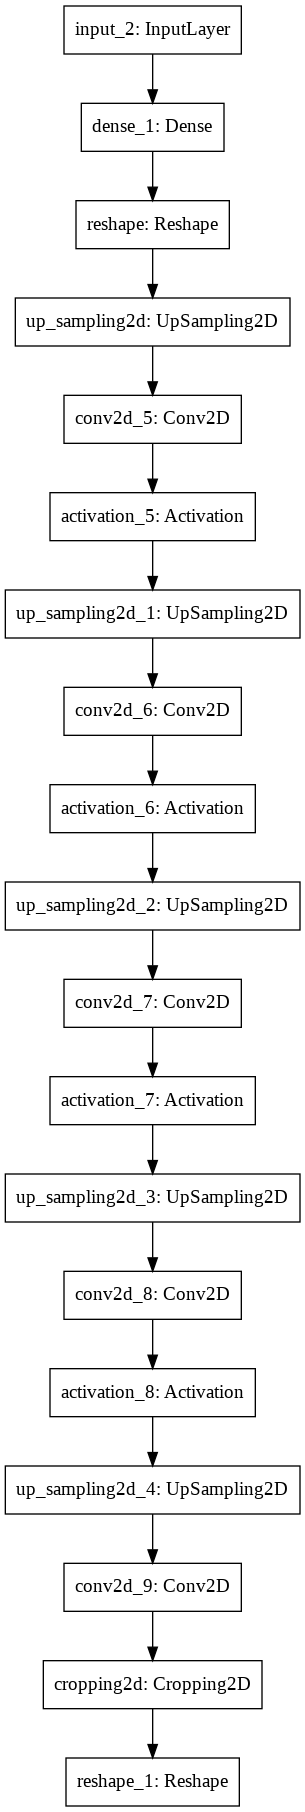

In [ ]:
def get_decoder_model():
    decoder = tf.keras.Sequential(name='decoder')
    decoder.add(tf.keras.layers.InputLayer((latent_size,)))
    decoder.add(tf.keras.layers.Dense(128))
    decoder.add(tf.keras.layers.Reshape((1,1,128)))
    
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding='same'))
    decoder.add(tf.keras.layers.Activation('relu'))
      
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding='same'))
    decoder.add(tf.keras.layers.Activation('relu'))
    
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same'))
    decoder.add(tf.keras.layers.Activation('relu'))
        
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(32, kernel_size=3, padding='same'))
    decoder.add(tf.keras.layers.Activation('relu'))
    
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same'))
    # decoder.add(tf.keras.layers.Activation('relu'))

    decoder.add(tf.keras.layers.Cropping2D(cropping=2))
    decoder.add(tf.keras.layers.Reshape((x_size,y_size,3)))
    
    return decoder


decoder = get_decoder_model()
plot_model(decoder)

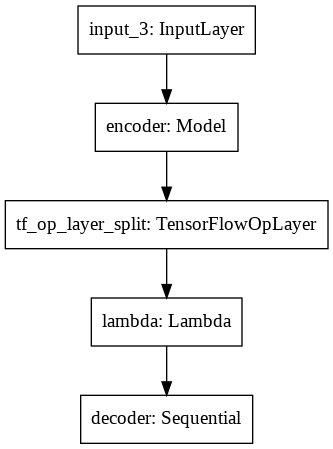

In [ ]:
inputs = tf.keras.Input((x_size,y_size,3))
z_mean, z_log_sigma = tf.split(encoder(inputs), num_or_size_splits=2, axis=1)
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_size,))([z_mean, z_log_sigma])
outputs = decoder(z)
vae = tf.keras.Model(inputs, outputs, name='CVAE')

plot_model(vae)

In [ ]:
# SK: This is a simplified version of ELBO loss, not gauranteed to give good result, u should modify it accordingly basic idea is how you can define custom loss.
# SK: [**important] When you evaluate ELBO don't judge its performance by looking at accuracy -- check if your loss is decreasing or not
# Something very important to note is that how you define accuracy?? Try to think about it. You know very well what accuracy means in terms of classification but what about here?

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=outputs, labels=inputs)
log_pxz = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
log_pz = log_normal_pdf(z, 0., 0.)
log_qzx = log_normal_pdf(z, z_mean, z_log_sigma)
ELBO_loss = -tf.reduce_mean(log_pxz + log_pz - log_qzx)

vae.add_loss(ELBO_loss) # SK: [**important] when u use any intermediate values (eg z, z_mean, etc) for defining loss. Add your loss this way so that tf can build your computation graph accordingly

# SK: Custom metric as I removed sigmoid from output layers
def acc_metric(y_true, y_pred):
    acc = tf.keras.metrics.categorical_accuracy(y_true, tf.math.sigmoid(y_pred))
    return acc

In [1]:
# # vae.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
# opt = tf.keras.optimizers.Adadelta(1e-4)
# vae.compile(optimizer=opt, metrics=[acc_metric])

# vae.fit(ds_trains, epochs=5000)

In [ ]:
tfds.disable_progress_bar()
tf.enable_v2_behavior()

x_size, y_size = 28, 28

# SK: load as supervised => u will get tuple instead of dictionary
ds_trains = tfds.load(
    'omniglot',
    split='train',
    shuffle_files=True,
    with_info=False,
    as_supervised=True,
)

def normalize_img(image, label):
  image = tf.image.resize(image, [x_size, y_size]) 
  image = tf.cast(image, tf.float32) / 255.
  # image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  # image = tf.image.random_crop(image, size=[28, 28, 3]) # Random crop back to 28x28
  # image = tf.image.random_brightness(image, max_delta=0.5) # Random brightnes
  return image,image # SK: replace labels with input images >> will be easy at model.fit

ds_trains = ds_trains.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE) # SK: resize and normalise
ds_trains = ds_trains.cache() # SK: to store it in memory > will yield faster run
ds_trains = ds_trains.shuffle(1000) # SK: will shuffle the dataset for randomness
ds_trains = ds_trains.batch(128) # SK: take small random batches of 128 
ds_trains = ds_trains.prefetch(tf.data.experimental.AUTOTUNE)

# opt = tf.keras.optimizers.Adadelta(1e-100)
# vae.compile(optimizer=opt, metrics=[acc_metric])

# vae.fit(ds_trains, epochs=5)

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

checkpoint_path = "save/cpe.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#Loading previous saved model

2.2.0


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

checkpoint_path = "/content/cp.ckpt"

inputs = tf.keras.Input((x_size,y_size,3))
z_mean, z_log_sigma = tf.split(encoder(inputs), num_or_size_splits=2, axis=1)
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_size,))([z_mean, z_log_sigma])
outputs = decoder(z)
model = tf.keras.Model(inputs, outputs, name='CVAE')

opt = tf.keras.optimizers.Adadelta(1e-100)
model.compile(optimizer=opt, metrics=[acc_metric])
# plot_model(vae)
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss,acc = model.evaluate(ds_trains, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

2.2.0
151/151 - 3s - loss: 0.0000e+00 - acc_metric: 0.3434
Restored model, accuracy: 34.34%




Sample: 42 >>>>>>>>>>>>>>>>>>>
ORIGINAL-->



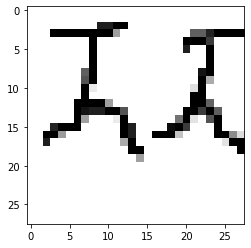


GENERATED-->



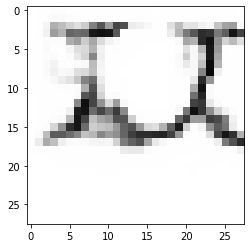



Sample: 77 >>>>>>>>>>>>>>>>>>>
ORIGINAL-->



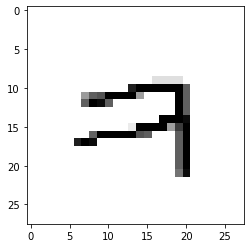


GENERATED-->



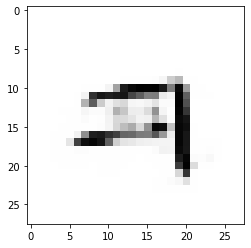



Sample: 74 >>>>>>>>>>>>>>>>>>>
ORIGINAL-->



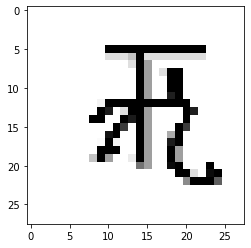


GENERATED-->



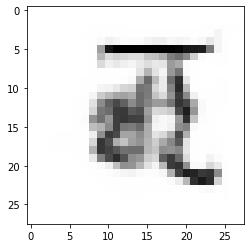



Sample: 4 >>>>>>>>>>>>>>>>>>>
ORIGINAL-->



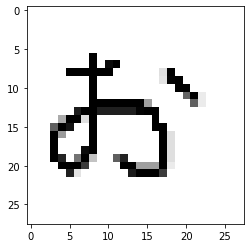


GENERATED-->



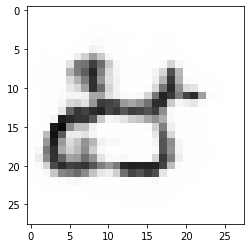



Sample: 105 >>>>>>>>>>>>>>>>>>>
ORIGINAL-->



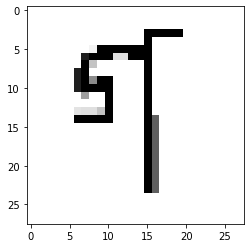


GENERATED-->



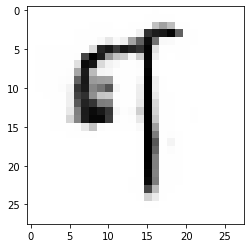

In [ ]:
for example in ds_trains.take(1):
  image = example[0]
  
  for i in np.random.choice(128, size=5, replace=False):
    print("\n\nSample:", i, ">>>>>>>>>>>>>>>>>>>")
    print("ORIGINAL-->\n")
    plt.imshow(image[i])
    plt.show()

    print("\nGENERATED-->\n")
    pred = (vae.predict(image)[i])
    pred = tf.math.sigmoid(pred).numpy()
    plt.imshow(pred.reshape((28,28,3)))
    plt.show()

In [ ]:
i = np.random.choice(np.arange(80))

In [ ]:
for example in ds_trains.take(1):
  image = example[0]
def sample(mn,std):
  return np.random.normal(mn,np.exp(std),size=(5,latent_size))
i = 46
print(i)
plt.imshow(image[i])
plt.show()
pred = vae.predict(image)
plt.imshow(pred[i])
plt.show()
enc = encoder.predict(image)
x = (enc[i])
mn = x[:latent_size]
std = x[latent_size:]
z = sample(mn,std)
z=z.reshape(5,latent_size)
y = decoder.predict(z)

for i in range(5):
  plt.imshow(y[i])
  plt.show()

plt.show()

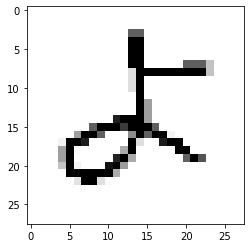

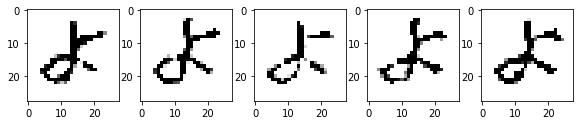

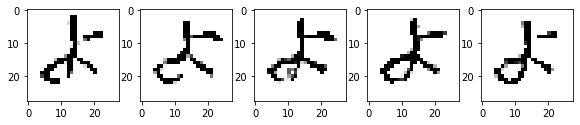

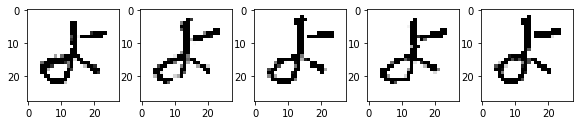

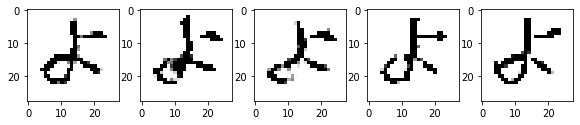

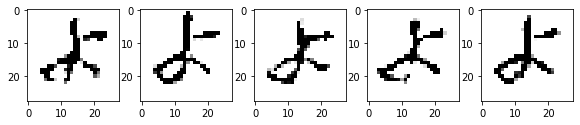

In [ ]:
def sample(mn,std):
  return np.random.normal(mn,np.exp(std),size=(5,latent_size))
i = 26
# print(i)
# plt.imshow(image[i])
# plt.show()
# pred = vae.predict(image)
# plt.imshow(pred[i])
# plt.show()
enc = encoder.predict(image)
plt.imshow(image[i])
x = (enc[i])
mn = x[:latent_size]
std = x[latent_size:]
t=1
p=129
for k in [p,p,p,p,p]:
  z = sample(mn,std*k)
  z=z.reshape(5,latent_size)
  y = decoder.predict(z)
  img1=y[0]
  img2=y[1]
  img3=y[2]
  img4=y[3]
  img5=y[4]
  # for i in range(5):
  #   plt.imshow(y[i])
  #   plt.show()
  plt.figure(figsize=(20,20))
  plt.subplot(10, 10, 5*t + 1), plt.imshow(img1)
  plt.subplot(10, 10, 5*t + 2), plt.imshow(img2)
  plt.subplot(10, 10, 5*t + 3), plt.imshow(img3)
  plt.subplot(10, 10, 5*t + 4), plt.imshow(img4)
  plt.subplot(10, 10, 5*t + 5), plt.imshow(img5)
  t+=1
plt.show()